## Required Data Downloads:

[Kaggle facial keypoints dataset](https://www.kaggle.com/c/facial-keypoints-detection/data) (download will be named all.zip)

In [1]:
import zipfile
import numpy as np
import os
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.saved_model import tag_constants

c:\users\sorgm\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.python.ops import gen_list_ops

In [3]:
def unpack(filename, current_file_directory = '', extract_to_directory = ''):
    """
    Extracts the zipfile in the same location of the 
    """
    with zipfile.ZipFile(os.path.join(current_file_directory,filename)) as (zf):
        zf.extractall(path = extract_to_directory)

In [4]:
MAX_IMG_VALUE = 255
IMG_SHAPE = (1,96,96,1) # IMG_SHAPE[3] == 1 because these are greyscale imgs

In [5]:
cwd = os.getcwd()
data_dir = os.path.join(cwd,'data')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [6]:
#be careful to remember where you extract to and from if you're not doing so in the working directory.

unpack('all.zip', extract_to_directory = data_dir)
unpack('test.zip', current_file_directory = data_dir, extract_to_directory = data_dir)
unpack('training.zip', current_file_directory = data_dir, extract_to_directory = data_dir)

# Keep the base all.zip files, but remove the sub zip files and just keep the final data
try:
    os.remove(os.path.join(data_dir, 'test.zip'))
except OSError:
    print('test.zip didn\'t get unpacked from all.zip')

try:
    os.remove(os.path.join(data_dir, 'training.zip'))
except OSError:
    print('training.zip didn\'t get unpacked from all.zip')

Now we have files:
* IdLookupTable.csv
* training.csv
* test.csv
* SampleSubmission.csv (not something we'll use)


In [7]:
with open(os.path.join(data_dir,'IdLookupTable.csv'), 'r') as IdLookupTable_csv:
    print(IdLookupTable_csv.readline())
    print(IdLookupTable_csv.readline())
    print(IdLookupTable_csv.readline())
    print(IdLookupTable_csv.readline())
    print(IdLookupTable_csv.readline())

RowId,ImageId,FeatureName,Location

1,1,left_eye_center_x

2,1,left_eye_center_y

3,1,right_eye_center_x

4,1,right_eye_center_y



In [8]:
with open(os.path.join(data_dir,'training.csv'), 'r') as training:
    print(training.readline())
    print(np.array([int(num)/MAX_IMG_VALUE for num in training.readline().split(',')[-1].split(' ')]).reshape(96,96))
    print(np.array([float(pt) for pt in training.readline().split(',')[:-1]]))
    print(np.array([float(pt) for pt in training.readline().split(',')[:-1]]).shape)
    print(np.array([float(pt) for pt in training.readline().split(',')[:-1]][:4]))

left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image

[[0.93333333 0.9254902  0.92941176 ... 0.98039216 0.98039216 0.98039216]
 [0.92156863 0.93333333 0.9254902  ... 0.97647059 0.98039216 0.98431373]
 [0.92941176 0.9254902  0.92941176 ... 0.98431373 0.98431373 0.98039216]
 ...
 [0.72941176 0.71764706 0.70980392 ... 0.20392157 0.22352941 0.23529412]
 [0.74117647 0.73725

In [9]:
with open(os.path.join(data_dir,'test.csv'), 'r') as training:
    print(training.readline())
    print(training.readline().split(','))
    #print(np.array([int(num)/MAX_IMG_VALUE for num in training.readline().split(',')[-1].split(' ')]).reshape(96,96))
    #print(np.array([float(pt) for pt in training.readline().split(',')[:-1]]))
    #print(np.array([float(pt) for pt in training.readline().split(',')[:-1]]).shape)

ImageId,Image

['1', '182 183 182 182 180 180 176 169 156 137 124 103 79 62 54 56 58 48 49 45 39 37 42 43 52 61 78 93 104 107 114 115 117 122 120 122 118 114 115 118 117 123 122 122 112 113 118 125 124 122 109 101 96 102 108 107 100 89 76 67 58 48 44 36 32 21 12 5 15 21 24 33 32 41 52 63 71 90 106 121 152 173 180 183 182 182 183 182 182 181 182 182 183 182 182 182 182 181 181 181 182 179 177 162 136 106 84 64 49 44 40 50 50 42 36 33 32 43 51 67 77 94 106 121 124 128 127 126 128 128 129 126 126 122 128 123 128 123 129 127 133 123 128 129 135 127 122 111 115 118 120 121 118 114 107 107 99 89 74 70 59 47 29 18 16 22 25 25 34 39 45 51 52 60 84 97 124 157 175 181 183 182 183 182 184 181 183 183 183 182 182 182 182 181 180 183 182 180 176 152 111 77 59 45 36 40 51 48 37 29 29 33 45 61 81 95 107 113 120 126 129 128 132 132 130 132 132 132 131 133 130 132 129 130 133 137 136 137 135 137 137 134 129 125 126 131 131 128 128 124 124 122 121 111 105 98 86 72 62 42 27 20 19 14 15 27 40 36 27 41 56 

In [10]:
def parse_imgs_and_keypoints(file, file_path = '', resize_h = 100, resize_w = 100, max_imgs = None):
    with open(os.path.join(file_path,file), 'r') as data:
        #remove header
        data.readline()
        
        images = np.empty((0,96,96,1), float)
        key_points = np.empty([0,30], float)
        
        num_imgs = 0
        for line in data:
            if len(line.split(',')) <31:
                continue
            row = line.split(',')
            
   
            row_pts = np.array([float(pt) if pt != '' else None for pt in row[:-1]])
  
            
            image = np.array([float(num)/MAX_IMG_VALUE for num in row[-1].split(' ')])

            image = image.reshape(IMG_SHAPE)
            h, w = image.shape[1:3]

            #try:
            #    images = np.append(images, image, axis = 0)
            #except:
            #    print(image.shape)
            
            pts_scaled = np.array([row_pts], dtype = np.float32)
            pts_scaled = np.array([pts_scaled[i]/h if i %2 ==0 else pts_scaled[i]/w for i in range(len(pts_scaled))])
            pts_scaled -= 0.5
            images = np.vstack((images,image))
            
            key_points = np.vstack((key_points, pts_scaled))
            
            num_imgs += 1
            if max_imgs is not None and num_imgs >= max_imgs:
                break
    return key_points, images

In [ ]:
key_pts, imgs = parse_imgs_and_keypoints(os.path.join(data_dir,'training.csv'), max_imgs = 10000)

In [ ]:
# only care about they eyes
key_pts = key_pts[:,:4]

In [ ]:
imgs.shape

In [ ]:
key_pts.shape

In [15]:
key_pts[0]

array([ 0.18784958, -0.09372631, -0.18513533, -0.12060753])

In [31]:
def parse_test_data():
    # The test data doesn't contain key point information. It's what you're tested against in the Kaggle competition
    # I just want the dataset so I'll make my own training and test data
    pass

In [35]:
# 60 - 20 -20,  train -val -test split
imgs_train, imgs_test, key_pts_train, key_pts_test = train_test_split(imgs, key_pts, test_size = .2)
imgs_train, imgs_val, key_pts_train, key_pts_val = train_test_split(imgs_train, key_pts_train, test_size = .25)

In [36]:
imgs_train.shape

(60, 96, 96, 1)

array([ 0.19455147, -0.1464456 , -0.18006617, -0.12344265])

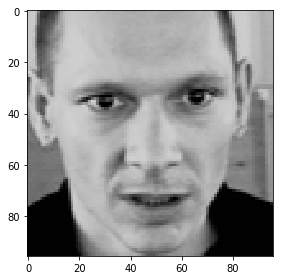

In [37]:
# Example image
%matplotlib inline
from skimage.io import imshow
imshow(imgs_train[3,:,:,0])
key_pts_train[3]

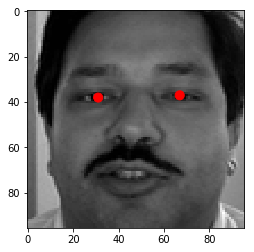

In [38]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    cur_img = img[:,:,0]
    cur_points = points[:] + .5
    cur_points *= cur_img.shape[0]
    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')
    
    ax.imshow(cur_img, cmap = "gray")
    for i in range(0,len(cur_points),2):
        c = Circle((int(cur_points[i]), int(cur_points[i+1])), 2, color = 'red')
        #print((int(cur_points[i]), int(cur_points[i+1])))
        ax.add_patch(c)
    
    plt.show()
    
    
visualize_points(imgs_train[0], key_pts_train[0])

In [39]:
imgs_train[3].shape

(96, 96, 1)

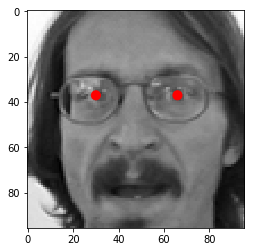

In [40]:
comparisson_img = 4
visualize_points(imgs_train[comparisson_img], key_pts_train[comparisson_img])

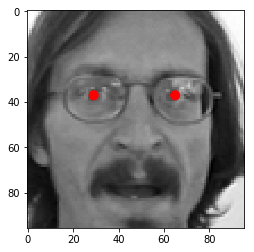

In [41]:
def flip_img(img, points):
    
    img_flipped = np.flip(img, axis = 1)
    
    #flipped_points = np.array([-(points[i] - int(img.shape[0]/2)) + int(img.shape[0]/2) if i%2 == 0 else points[i] for i in range(len(points))])
    flipped_points = np.array([-points[i] if i%2 == 0 else points[i] for i in range(len(points))])
    #flipped_points = points[:]
    #flipped_points[::2] = -1*flipped_points[::2]
    return(img_flipped, flipped_points)
        

f_img, f_points = flip_img(imgs_train[comparisson_img], key_pts_train[comparisson_img])
visualize_points(f_img, f_points)

In [42]:
aug_imgs_train, aug_points_train = zip(*[flip_img(imgs_train[i], key_pts_train[i]) for i in range(len(imgs_train))])

In [43]:
# add to train imgs_train, imgs_val, points_train, points_val
imgs_train = np.vstack((imgs_train, aug_imgs_train))
key_pts_train = np.vstack((key_pts_train, aug_points_train))

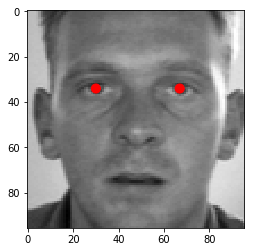

In [44]:
comparisson_img2 = 2
visualize_points(imgs_train[comparisson_img2], key_pts_train[comparisson_img2])

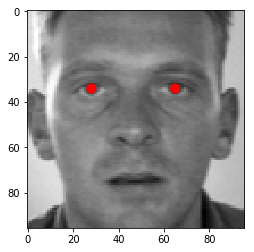

In [45]:
visualize_points(aug_imgs_train[comparisson_img2], aug_points_train[comparisson_img2])

In [46]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)

outputs = key_pts.shape[1] # 30
input_shape = imgs.shape[1:] # (96,96,1)

model = Sequential()
# Define here your model
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same', input_shape = input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(outputs, activation='softmax'))
#model.summary()

Using TensorFlow backend.


In [47]:
def create_placeholders(graph, num_out_classes, input_shape = IMG_SHAPE):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    input_shape     -- list    [1] -- scalar, height of an input image
                               [2] -- scalar, width of an input image
                               [3] -- scalar, number of channels of the input
    num_out_classes -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, input_shape[1], input_shape[2], input_shape[3] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """
    with graph.as_default():
        X = tf.placeholder(tf.float32, shape = [None, input_shape[1], input_shape[2], input_shape[3]], name = 'X')
        Y = tf.placeholder(tf.float32, shape = [None, num_out_classes], name = 'Y')

        return X, Y

In [48]:
def initialize_parameters(graph, conv_params = [[3,3,1,16], [3,3,16,32], [3,3,32,64], [3,3,64,128]], dense_params = [[35344, 512]], seed = 0):
    """
    Initializes weight parameters to build a neural network with tensorflow. 
    
    Returns:
    parameters -- a dictionary of tensors containing parameters
    """
    with graph.as_default():
        if seed:
            tf.set_random_seed(seed)            

        i = 0
        parameters = {}

        if conv_params:
            for cp in conv_params:
                parameters["Wc" + str(i+1)] = \
                          tf.get_variable("Wc" + str(i+1),  
                                          cp, 
                                          initializer = tf.contrib.layers.xavier_initializer_conv2d()
                                         )
                i += 1
                # initializer = tf.contrib.layers.variance_scaling_initializer(seed = seed)
                # initializer = tf.contrib.layers.xavier_initializer_conv2d(seed = 0)

        if dense_params:
            for dp in dense_params:
                feature_weights = dp
                bias_terms = dp[1]
                parameters["Wfc" + str(i + 1)] = \
                    tf.Variable( tf.random_uniform( dp , minval=0.1, maxval=0.9, dtype=tf.float32 ))

                parameters["b" + str(i + 1)] = \
                    tf.Variable( tf.random_uniform( [dp[1]] , minval=0.1, maxval=0.9, dtype=tf.float32 ))




        return parameters

In [49]:
def conv_net_v1(X, parameters, keep_prob = .8):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED -> DROPCONNECT -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Y_pred -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['Wc1']
    W2 = parameters['Wc2']
    
    Wfc3 = parameters['Wfc3']
    b3 = parameters['b3']
    
    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1_stride = 1
    Z1 = tf.nn.conv2d(X,W1, strides = [1,Z1_stride,Z1_stride,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1_w = 2
    P1_s = 2
    P1 = tf.nn.max_pool(A1, ksize = [1,P1_w,P1_w,1], strides = [1,P1_s,P1_s,1], padding = 'SAME')
    
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2_s = 1
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,Z2_s,Z2_s,1], padding = 'SAME')
    
    # RELU
    A2 = tf.nn.relu(Z2)
    
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2_w = 2
    P2_s = 2
    P2 = tf.nn.max_pool(A2, ksize = [1,P2_w,P2_w,1], strides = [1,P2_s,P2_s,1], padding = 'SAME')
    
    # FLATTEN 
    # input shape of 96. First max pool means 96/2, second means 48/2
    # 24 *24 * 64
    P2 = tf.contrib.layers.flatten(P2)
    
    # DROPCONNECT
    dropConnect = tf.nn.dropout( Wfc3, keep_prob ) * keep_prob
    
    
    # FULLY-CONNECTED
    Z3_output = 128
    Z3 = tf.nn.relu( tf.matmul( P2, dropConnect ) + b3 ) 
    
    #Z3 = tf.contrib.layers.fully_connected(P2, Z3_output, activation_fn = tf.nn.relu)   
    
    # FULLY-CONNECTED output layer
    
    Z4_output = key_pts.shape[1]
    Y_pred = tf.contrib.layers.fully_connected(Z3, Z4_output, activation_fn = None)


    return Y_pred

In [50]:
def conv_net_v2(graph, X, parameters, keep_prob = .8):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> 
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> 
    FLATTEN -> FULLYCONNECTED -> DROPCONNECT -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Y_pred -- the output of the last LINEAR unit
    """
    
    
    with graph.as_default():
        # Retrieve the parameters from the dictionary "parameters" 
        W1 = parameters['Wc1']
        W2 = parameters['Wc2']
        W3 = parameters['Wc3']
        W4 = parameters['Wc4']

        Wfc5 = parameters['Wfc5']
        b5 = parameters['b5']

        # CONV2D: stride of 1
        Z1_stride = 1
        if X.dtype == 'float64':
            X = tf.cast(X, 'float32')
        Z1 = tf.nn.conv2d(X,W1, strides = [1,Z1_stride,Z1_stride,1], padding = "VALID")
        # RELU
        A1 = tf.nn.relu(Z1)

        # MAXPOOL: window 8x8, sride 8, padding 'SAME'
        P1_w = 2
        P1_s = 2
        P1 = tf.nn.max_pool(A1, ksize = [1,P1_w,P1_w,1], strides = [1,P1_s,P1_s,1], padding = 'SAME')

        # CONV2D: filters W2, stride 1
        Z2_s = 1
        Z2 = tf.nn.conv2d(P1,W2, strides = [1,Z2_s,Z2_s,1], padding = "VALID")

        # RELU
        A2 = tf.nn.relu(Z2)

        # MAXPOOL: window 4x4, stride 4, padding 'SAME'
        P2_w = 2
        P2_s = 2
        P2 = tf.nn.max_pool(A2, ksize = [1,P2_w,P2_w,1], strides = [1,P2_s,P2_s,1], padding = 'SAME')


        # CONV2D: stride of 1
        Z3_stride = 1
        Z3 = tf.nn.conv2d(X,W1, strides = [1,Z3_stride,Z3_stride,1], padding = "VALID")
        # RELU
        A3 = tf.nn.relu(Z3)

        # MAXPOOL: window 8x8, sride 8, padding 'SAME'
        P3_w = 2
        P3_s = 2
        P3 = tf.nn.max_pool(A3, ksize = [1,P3_w,P3_w,1], strides = [1,P3_s,P3_s,1], padding = 'SAME')


        # CONV2D: stride of 1
        Z4_stride = 1
        Z4 = tf.nn.conv2d(X,W1, strides = [1,Z4_stride,Z4_stride,1], padding = "VALID")
        # RELU
        A4 = tf.nn.relu(Z4)

        # MAXPOOL: window 8x8, sride 8, padding 'SAME'
        P4_w = 2
        P4_s = 2
        P4 = tf.nn.max_pool(A4, ksize = [1,P4_w,P4_w,1], strides = [1,P4_s,P4_s,1], padding = 'SAME')     


        # FLATTEN 
        # input shape of 96. First max pool means 96/2, second means 48/2
        # 24 *24 * 64
        P4 = tf.contrib.layers.flatten(P4)

        # DROPCONNECT
        dropConnect = tf.nn.dropout( Wfc5, keep_prob ) * keep_prob


        # FULLY-CONNECTED
        Z5_output = 128
        Z5 =  tf.matmul( P4, dropConnect )
        Z5 = tf.nn.relu(Z5 + b5)

        #Z3 = tf.contrib.layers.fully_connected(P2, Z3_output, activation_fn = tf.nn.relu)   

        # FULLY-CONNECTED output layer

        Z5_output = key_pts.shape[1]
        Y_pred = tf.contrib.layers.fully_connected(Z5, Z5_output, activation_fn = None)
        
        

        return Y_pred

In [51]:
def compute_cost(graph, Y_pred, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    with graph.as_default():
        return tf.losses.mean_squared_error(Y, Y_pred)

In [52]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = np.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [53]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :].reshape((m, Y.shape[1]))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(np.floor(m/mini_batch_size)) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [55]:
tf.reset_default_graph()

graph_v2 = tf.Graph()

with graph_v2.as_default():
    with tf.Session() as sess:
        np.random.seed(1)
        X, Y = create_placeholders(graph_v2, key_pts.shape[1], IMG_SHAPE)
        parameters = initialize_parameters(graph_v2)
        Y_pred = conv_net_v2(graph_v2, X, parameters)
        cost = compute_cost(graph_v2, Y_pred, Y)
        init = tf.global_variables_initializer()
        sess.run(init)
        a = sess.run(cost, {X: np.random.randn(4,96,96,1), Y: np.random.randn(4,4)})
        print("cost = " + str(a))

cost = 54118788.0


In [56]:
35344/2048

17.2578125

In [57]:
#### TODO: https://www.tensorflow.org/guide/saved_model

##### EVEN MORE TODO: http://vict0rsch.github.io/2018/05/17/restore-tf-model-dataset/

### https://www.tensorflow.org/hub/creating

#### EVEN MORRRRREE TODO: https://cv-tricks.com/tensorflow-tutorial/save-restore-tensorflow-models-quick-complete-tutorial/

In [79]:
dirName = 'checkpoints'

if not os.path.exists(dirName):
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ")
else:    
    print("Directory " , dirName ,  " already exists")

Directory  checkpoints  Created 


In [92]:
def model_train_v2(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True, seed = 3):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, num_out_classes = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, num_out_classes = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    #ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    
    graph_v2 = tf.Graph()
    with graph_v2.as_default():
        tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
        seed = seed                                          # to keep results consistent (numpy seed)
        (m, n_H0, n_W0, n_C0) = X_train.shape             
        num_out_classes = Y_train.shape[1]                            
        costs = []                                        # To keep track of the cost

        test_costs = []
        epochs_of_test_costs = []


        # Create Placeholders of the correct shape
        X = tf.placeholder(tf.float32, shape = [None, n_H0, n_W0, n_C0], name = 'X')
        Y = tf.placeholder(tf.float32, shape = [None, num_out_classes], name = 'Y')
        #X, Y = create_placeholders(graph_v2, n_y, X_train.shape)


        # Initialize parameters
        parameters = initialize_parameters(graph_v2)


        # Forward propagation: Build the forward propagation in the tensorflow graph
        Y_pred = conv_net_v2(graph_v2, X, parameters)


        # Cost function: Add cost function to tensorflow graph
        cost = compute_cost(graph_v2, Y_pred, Y)


        # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)


        # Initialize all the variables globally
        init = tf.global_variables_initializer()


        # add ops to save and restore all the variables
        saver = tf.train.Saver()

        # Start the session to compute the tensorflow graph
        with tf.Session() as sess:

            # Run the initialization
            sess.run(init)

            # Do the training loop
            for epoch in range(num_epochs):

                minibatch_cost = 0.
                num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
                seed = seed + 1
                minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

                for minibatch in minibatches:

                    # Select a minibatch
                    (minibatch_X, minibatch_Y) = minibatch
                    # IMPORTANT: The line that runs the graph on a minibatch.
                    # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).

                    _ , temp_cost = sess.run([optimizer,cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})


                    minibatch_cost += temp_cost / num_minibatches


                # Print the cost every epoch
                if print_cost == True and epoch % 5 == 0:
                    print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
                if print_cost == True and epoch % 1 == 0:
                    costs.append(minibatch_cost)

                if print_cost == True and epoch % 10 == 0 and epoch > 0:
                    test_cost = sess.run([cost], feed_dict = {X: X_test, Y: Y_test})
                    test_costs.append(test_cost)
                    epochs_of_test_costs.append(epoch)
                    print ("\nTest cost after epoch %i: %f\n" % (epoch, test_cost[0]))
                    '''
                    # Calculate the correct predictions
                    predict_op = tf.argmax(Y_pred, 1)
                    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

                    # Calculate accuracy on the test set
                    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

                    mse = tf.losses.mean_squared_error(Y_pred, Y)
                    test_accuracy = mse.eval({X: X_test, Y: Y_test})
                    print ("Test Accuracy after epoch %i: %f" % (epoch, test_accuracy))
                '''

            # plot the cost without the first wildly off epoch
            plt.plot(np.squeeze(costs[10:]), 'b-')
            plt.plot(epochs_of_test_costs, test_costs, 'g-')
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()


            train_cost = cost.eval({X: X_train, Y: Y_train})
            test_cost = cost.eval({X: X_test, Y: Y_test})
            print("Train Cost:", train_cost)
            print("Test Cost:", test_cost)
            #print(Y_pred.eval({X: X_test, Y: Y_test}))


            #save_path = saver.save(sess, os.path.join(os.getcwd(),'model_v2.ckpt'))
            #saver.save(sess, os.path.join(os.getcwd(),'model_v2'),global_step=1000)
            #print("Model saved in %s" % save_path)
            
            path = os.path.join(os.getcwd(), 'model_v2_2')
            inputs_dict = {
                'X': X,
                'Y': Y
            }
            
            outputs_dict = {
                'Y_pred': Y_pred
            } 
            tf.saved_model.simple_save(
                sess, path, inputs_dict, outputs_dict
            )
            
            saver.save(sess, os.path.join(os.getcwd(), 'checkpoints', 'model_v2_chkpt'), global_step = 100)

            return train_cost, test_cost, parameters, path

Cost after epoch 0: 9706162.625000
Cost after epoch 5: 43521.443848
Cost after epoch 10: 24.172334

Test cost after epoch 10: 6.127032

Cost after epoch 15: 17.530119
Cost after epoch 20: 16.785570

Test cost after epoch 20: 6.283937

Cost after epoch 25: 16.401092
Cost after epoch 30: 16.249947

Test cost after epoch 30: 6.300441

Cost after epoch 35: 16.150889
Cost after epoch 40: 16.019902

Test cost after epoch 40: 6.203420

Cost after epoch 45: 15.930531


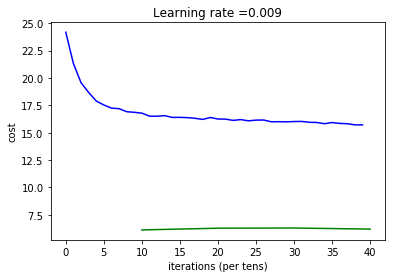

Train Cost: 7.855172
Test Cost: 6.095293
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: G:\Projects\celebrity-recognition\model_v2_2\saved_model.pb


In [93]:
# imgs_train, imgs_test, key_pts_train, key_pts_test

train_acc, test_acc, parameters, model_v2_path = model_train_v2(imgs_train, key_pts_train, imgs_test, key_pts_test, num_epochs = 50)

In [89]:
graph2 = tf.Graph()
with graph2.as_default():
    with tf.Session(graph=graph2) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            model_v2_path
        )

        # Get restored placeholders
        Y = graph2.get_tensor_by_name('Y:0')
        X = graph2.get_tensor_by_name('X:0')
        
        # Get restored model output
        restored_logits = graph2.get_tensor_by_name('fully_connected/BiasAdd:0')
        
        
        print(sess.run(restored_logits, {X: imgs_val, Y: key_pts_val}))
        # Get dataset initializing operation
        #dataset_init_op = graph2.get_operation_by_name('dataset_init')
           


Restoring...
INFO:tensorflow:Restoring parameters from G:\Projects\celebrity-recognition\model_v2_2\variables\variables
[[ 4.79433   -2.3088012  4.023412  -2.2254388]
 [ 3.5900059 -1.4276024  2.8311691 -1.3736593]
 [ 3.5900059 -1.4276024  2.8311691 -1.3736593]
 [ 3.8479395 -1.6373782  3.1245325 -1.5832689]
 [ 3.7219713 -1.5251255  2.955474  -1.4511937]
 [ 3.9018278 -1.6424117  3.1327162 -1.588082 ]
 [ 3.5900059 -1.4276024  2.8311691 -1.3736593]
 [ 3.6952257 -1.5291579  2.9580295 -1.4546863]
 [ 4.1120224 -1.793756   3.3264904 -1.776594 ]
 [ 3.5900059 -1.4276024  2.8311691 -1.3736593]
 [ 3.665842  -1.4793017  2.9137678 -1.4336444]
 [ 3.5900059 -1.4276024  2.8311691 -1.3736593]
 [ 7.0776644 -3.881476   6.140025  -3.8627038]
 [ 3.6058433 -1.4354644  2.8458285 -1.3800155]
 [ 3.615553  -1.4419662  2.8551004 -1.3958668]
 [ 3.6098747 -1.4466431  2.8573558 -1.39279  ]
 [ 3.6056914 -1.4377925  2.8443675 -1.3808817]
 [ 3.928791  -1.6545535  3.0989494 -1.5804175]
 [ 3.7332358 -1.513602   2.974341

In [98]:
import tensorflow as tf
 
sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(os.path.join(os.getcwd(), 'checkpoints','model_v2_chkpt-100.meta'))
#saver.restore(sess,tf.train.latest_checkpoint('./'))
saver.restore(sess,tf.train.latest_checkpoint(os.path.join(os.getcwd(), 'checkpoints')))

graph = tf.get_default_graph()
Y = graph.get_tensor_by_name('Y:0')
X= graph.get_tensor_by_name('X:0')
feed_dict ={X: imgs_val, Y: key_pts_val}
 
#Now, access the op that you want to run. 
op_to_restore = graph.get_tensor_by_name('fully_connected/BiasAdd:0')
 
print(sess.run(op_to_restore,feed_dict))

INFO:tensorflow:Restoring parameters from G:\Projects\celebrity-recognition\checkpoints\model_v2_chkpt-100
[[ 4.7144265 -2.2701817  3.9632232 -2.170995 ]
 [ 3.5304315 -1.4064914  2.791821  -1.337472 ]
 [ 3.5304315 -1.4064914  2.791821  -1.337472 ]
 [ 3.782043  -1.610051   3.07794   -1.5408825]
 [ 3.6591012 -1.5013173  2.913219  -1.4122592]
 [ 3.83053   -1.6120335  3.0818982 -1.5422313]
 [ 3.5304315 -1.4064914  2.791821  -1.337472 ]
 [ 3.6319196 -1.503729   2.9137962 -1.4146703]
 [ 4.046484  -1.766954   3.2811646 -1.7338251]
 [ 3.5304315 -1.4064914  2.791821  -1.337472 ]
 [ 3.6047752 -1.4568431  2.8726718 -1.395826 ]
 [ 3.5304315 -1.4064914  2.791821  -1.337472 ]
 [ 6.9650583 -3.8174994  6.049202  -3.7790706]
 [ 3.54593   -1.4141475  2.806155  -1.3436439]
 [ 3.5556343 -1.4205941  2.8154044 -1.3592569]
 [ 3.5487826 -1.423978   2.815948  -1.3550196]
 [ 3.545138  -1.4160002  2.8041885 -1.3441938]
 [ 3.864991  -1.6292526  3.0558953 -1.540286 ]
 [ 3.6688707 -1.4890919  2.9302714 -1.4386544]


In [211]:
labels

<tf.Tensor 'Y:0' shape=(?, 30) dtype=float32>

In [219]:
restored_logits

<tf.Tensor 'fully_connected/BiasAdd:0' shape=(?, 30) dtype=float32>

In [76]:
graph2 = tf.Graph()
with graph2.as_default():
    with tf.Session(graph=graph2) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            model_v2_path
        )
        print(graph2.get_all_collection_keys())


Restoring...
INFO:tensorflow:Restoring parameters from G:\Projects\celebrity-recognition\model_v2_2\variables\variables
['losses', 'model_variables', 'train_op', 'trainable_variables', 'variables']


In [77]:
graph2 = tf.Graph()
with graph2.as_default():
    with tf.Session(graph=graph2) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            model_v2_path
        )
        i = 0
        for v in graph2.get_collection("model_variables"):
            print(v)
            i +=1
            #if i > 10:
            #   break


Restoring...
INFO:tensorflow:Restoring parameters from G:\Projects\celebrity-recognition\model_v2_2\variables\variables
<tf.Variable 'fully_connected/weights:0' shape=(512, 4) dtype=float32_ref>
<tf.Variable 'fully_connected/biases:0' shape=(4,) dtype=float32_ref>


In [87]:
graph2 = tf.Graph()
with graph2.as_default():
    with tf.Session(graph=graph2) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            model_v2_path
        )
        print(graph2.get_operations())


Restoring...
INFO:tensorflow:Restoring parameters from G:\Projects\celebrity-recognition\model_v2_2\variables\variables
[<tf.Operation 'X' type=Placeholder>, <tf.Operation 'Y' type=Placeholder>, <tf.Operation 'Wc1/Initializer/random_uniform/shape' type=Const>, <tf.Operation 'Wc1/Initializer/random_uniform/min' type=Const>, <tf.Operation 'Wc1/Initializer/random_uniform/max' type=Const>, <tf.Operation 'Wc1/Initializer/random_uniform/RandomUniform' type=RandomUniform>, <tf.Operation 'Wc1/Initializer/random_uniform/sub' type=Sub>, <tf.Operation 'Wc1/Initializer/random_uniform/mul' type=Mul>, <tf.Operation 'Wc1/Initializer/random_uniform' type=Add>, <tf.Operation 'Wc1' type=VariableV2>, <tf.Operation 'Wc1/Assign' type=Assign>, <tf.Operation 'Wc1/read' type=Identity>, <tf.Operation 'Wc2/Initializer/random_uniform/shape' type=Const>, <tf.Operation 'Wc2/Initializer/random_uniform/min' type=Const>, <tf.Operation 'Wc2/Initializer/random_uniform/max' type=Const>, <tf.Operation 'Wc2/Initializer/r

In [210]:
sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('model_v2-1000.meta')
saver.restore(sess,tf.train.latest_checkpoint('./'))

graph = tf.get_default_graph()

print(tf.get_default_graph().get_all_collection_keys())
for v in tf.get_default_graph().get_collection("variables"):
    print(v)


INFO:tensorflow:Restoring parameters from /Users/sorg/Projects/Computer-Vision/celebrity-recogntion/model_v2-1000
['losses', 'model_variables', 'train_op', 'trainable_variables', 'variables']
<tf.Variable 'Wc1:0' shape=(3, 3, 1, 16) dtype=float32_ref>
<tf.Variable 'Wc2:0' shape=(3, 3, 16, 32) dtype=float32_ref>
<tf.Variable 'Wc3:0' shape=(3, 3, 32, 64) dtype=float32_ref>
<tf.Variable 'Wc4:0' shape=(3, 3, 64, 128) dtype=float32_ref>
<tf.Variable 'Variable:0' shape=(35344, 512) dtype=float32_ref>
<tf.Variable 'Variable_1:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'fully_connected/weights:0' shape=(512, 30) dtype=float32_ref>
<tf.Variable 'fully_connected/biases:0' shape=(30,) dtype=float32_ref>
<tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>
<tf.Variable 'Wc1/Adam:0' shape=(3, 3, 1, 16) dtype=float32_ref>
<tf.Variable 'Wc1/Adam_1:0' shape=(3, 3, 1, 16) dtype=float32_ref>
<tf.Variable 'Variable/Adam:0' shape=(35344, 51

In [140]:
tf.reset_default_graph()
X, Y = create_placeholders(key_pts_test.shape[1], imgs_test.shape)
parameters = initialize_parameters()

saver = tf.train.Saver()

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, save_path)
    Y_pred = conv_net_v2(X, parameters)
    cost = compute_cost(Y_pred, Y)
    the_cost = sess.run([cost], feed_dict = {X: imgs_test, Y: key_pts_test})
    print(the_cost)
    #print(Y_pred.eval({X: imgs_test, Y: key_pts_test}, session = sess))

INFO:tensorflow:Restoring parameters from /Users/sorg/Projects/Computer-Vision/celebrity-recogntion/model_v2.ckpt


FailedPreconditionError: Attempting to use uninitialized value fully_connected/biases
	 [[node fully_connected/biases/read (defined at /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py:277)  = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](fully_connected/biases)]]

Caused by op 'fully_connected/biases/read', defined at:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-140-28113f52891e>", line 10, in <module>
    Y_pred = conv_net_v2(X, parameters)
  File "<ipython-input-98-b06d8244f314>", line 95, in conv_net_v2
    Y_pred = tf.contrib.layers.fully_connected(Z5, Z5_output, activation_fn = None)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1854, in fully_connected
    outputs = layer.apply(inputs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 817, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 374, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 746, in __call__
    self.build(input_shapes)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py", line 953, in build
    trainable=True)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 288, in add_weight
    getter=vs.get_variable)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 609, in add_weight
    aggregation=aggregation)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/checkpointable/base.py", line 639, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1487, in get_variable
    aggregation=aggregation)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1237, in get_variable
    aggregation=aggregation)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 523, in get_variable
    return custom_getter(**custom_getter_kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1749, in layer_variable_getter
    return _model_variable_getter(getter, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1740, in _model_variable_getter
    aggregation=aggregation)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 350, in model_variable
    aggregation=aggregation)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 277, in variable
    aggregation=aggregation)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 492, in _true_getter
    aggregation=aggregation)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 922, in _get_single_variable
    aggregation=aggregation)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 183, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 146, in _variable_v1_call
    aggregation=aggregation)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 125, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2444, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 187, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1329, in __init__
    constraint=constraint)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1491, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 81, in identity
    return gen_array_ops.identity(input, name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3454, in identity
    "Identity", input=input, name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value fully_connected/biases
	 [[node fully_connected/biases/read (defined at /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py:277)  = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](fully_connected/biases)]]


In [116]:
with tf.Session() as sess: 
    sess.run(Y_pred.eval({X: imgs_test}))

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder:0", shape=(?, 96, 96, 1), dtype=float32) is not an element of this graph.

In [114]:
with tf.Session() as sess: 
    sess.run(Y_pred, feed_dict = {X: imgs_test, Y: key_pts_test})

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder:0", shape=(?, 96, 96, 1), dtype=float32) is not an element of this graph.

In [ ]:
class Model(object):


    def __init__(self, model_path, X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
        """
        Implements a three-layer ConvNet in Tensorflow:
        CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

        Arguments:
        X_train -- training set, of shape (None, 64, 64, 3)
        Y_train -- test set, of shape (None, n_y = 6)
        X_test -- training set, of shape (None, 64, 64, 3)
        Y_test -- test set, of shape (None, n_y = 6)
        learning_rate -- learning rate of the optimization
        num_epochs -- number of epochs of the optimization loop
        minibatch_size -- size of a minibatch
        print_cost -- True to print the cost every 100 epochs

        Returns:
        train_accuracy -- real number, accuracy on the train set (X_train)
        test_accuracy -- real number, testing accuracy on the test set (X_test)
        parameters -- parameters learnt by the model. They can then be used to predict.
        """
        self.session = tf.session()
        
        tf.saved_model.loader.load(
            self.session,
            [tf.saved_model.tag_constants.SERVING],
            model_path)

        ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
        tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
        seed = 3                                          # to keep results consistent (numpy seed)
        (m, n_H0, n_W0, n_C0) = X_train.shape             
        n_y = Y_train.shape[1]                            
        costs = []                                        # To keep track of the cost

        test_costs = []
        epochs_of_test_costs = []
        # Create Placeholders of the correct shape

        X, Y = create_placeholders(n_y, X_train.shape)


        # Initialize parameters
        parameters = initialize_parameters()

        # Forward propagation: Build the forward propagation in the tensorflow graph
        Y_pred = conv_net(X, parameters)


        # Cost function: Add cost function to tensorflow graph
        cost = compute_cost(Y_pred, Y)


        # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)


        # Initialize all the variables globally
        init = tf.global_variables_initializer()

        # Start the session to compute the tensorflow graph
        with tf.Session() as sess:

            # Run the initialization
            sess.run(init)

            # Do the training loop
            for epoch in range(num_epochs):

                minibatch_cost = 0.
                num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
                seed = seed + 1
                minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

                for minibatch in minibatches:

                    # Select a minibatch
                    (minibatch_X, minibatch_Y) = minibatch
                    # IMPORTANT: The line that runs the graph on a minibatch.
                    # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).

                    _ , temp_cost = sess.run([optimizer,cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})


                    minibatch_cost += temp_cost / num_minibatches


                # Print the cost every epoch
                if print_cost == True and epoch % 5 == 0:
                    print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
                if print_cost == True and epoch % 1 == 0:
                    costs.append(minibatch_cost)

                if print_cost == True and epoch % 10 == 0 and epoch > 0:
                    test_cost = sess.run([cost], feed_dict = {X: X_test, Y: Y_test})
                    test_costs.append(test_cost)
                    epochs_of_test_costs.append(epoch)
                    print ("\nTest cost after epoch %i: %f\n" % (epoch, test_cost[0]))
                    '''
                    # Calculate the correct predictions
                    predict_op = tf.argmax(Y_pred, 1)
                    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

                    # Calculate accuracy on the test set
                    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

                    mse = tf.losses.mean_squared_error(Y_pred, Y)
                    test_accuracy = mse.eval({X: X_test, Y: Y_test})
                    print ("Test Accuracy after epoch %i: %f" % (epoch, test_accuracy))
                '''

            # plot the cost without the first wildly off epoch
            plt.plot(np.squeeze(costs[1:]), 'b-')
            plt.plot(epochs_of_test_costs, test_costs, 'g-')
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()


            train_cost = cost.eval({X: X_train, Y: Y_train})
            test_cost = cost.eval({X: X_test, Y: Y_test})
            print("Train Cost:", train_cost)
            print("Test Cost:", test_cost)

            return train_cost, test_cost, parameters, Y_pred

In [108]:
with tf.Session() as sess:
    Y_pred.eval({X: imgs_test})

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder:0", shape=(?, 96, 96, 1), dtype=float32) is not an element of this graph.

In [ ]:
import tensorflow as tf

outputs = key_pts.shape[1] # 30
input_shape = imgs.shape[1:] # (96,96,1)

def conv_net(x_dict, n_classes, dropout, reuse, is_training, input_shape = IMG_SHAPE):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['imgs']

        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]

        x = tf.reshape(x, shape=[-1, input_shape[1], input_shape[2], input_shape[3]])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.nn.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.nn.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out